In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import gdal
import matplotlib.pyplot as plt

In [ ]:
imagePath = '/content/DJI_0014.JPG'

## Super Pixel Hierarchical Clustering

In [ ]:
import matplotlib.pyplot as plt, argparse, numpy as np, math, sys, copy
from skimage.segmentation import slic, mark_boundaries
from skimage.util import img_as_float
from skimage import io
from collections import defaultdict

In [ ]:
#SLIC Parameters:
numSegments = 5  # How many superpixels to start with - input for SLIC function
Sigma = 4 # This parameter controls superpixel shape. Higher values make superpixels more square.

#SPHC Parameters:
segmentsToMerge = 2 # How many superpixels to merge based on color similarity
distance_limit = .6  # Limits which segments get merged based on their difference in average color

In [ ]:
def initiateSegmentAttributes(segm_grid, image):
    '''
    Each segment formed by sklearn's SLIC function is assigned a dictionary of attributes for efficiency.
    :param segm_grid: Each pixel has been identified with a segment identifier by the skimage SLIC function
    :param image: Each pixel has R, B, and G value associated with it
    :return: Dictionary of dictionaries of attributes for each segment
    '''
    def initialSegmAttr():
        return {'neighbors': set(), 'R': [], 'G': [], 'B': [], 'coord': set(),
                         'R_avg': 0.0, 'G_avg': 0.0, 'B_avg': 0.0}
    segm_dict = defaultdict(initialSegmAttr)

    for i in range(len(segm_grid)):
        for j in range(len(segm_grid[i])):
            if j < len(segm_grid[i]) - 1 and segm_grid[i][j] < segm_grid[i][j+1]:
                segm_dict[segm_grid[i][j]]['neighbors'].add(segm_grid[i][j+1])
                segm_dict[segm_grid[i][j+1]]['neighbors'].add(segm_grid[i][j])
            if i < len(segm_grid) - 1 and segm_grid[i][j] < segm_grid[i+1][j]:
                segm_dict[segm_grid[i][j]]['neighbors'].add(segm_grid[i+1][j])
                segm_dict[segm_grid[i+1][j]]['neighbors'].add(segm_grid[i][j])
            segm_dict[segm_grid[i][j]]['R'].append(image[i][j][0])
            segm_dict[segm_grid[i][j]]['B'].append(image[i][j][1])
            segm_dict[segm_grid[i][j]]['G'].append(image[i][j][2])
            segm_dict[segm_grid[i][j]]['coord'].add((i,j))
    return segm_dict

def getNearestNeighbors(segm_dict):
    '''
    Calculates the average R, B, and G values for each segment. Then finds the two neighboring segments with
    the smallest euclidean distance (for the three dimensions of R, B, and G).
    :param segm_dict: dictionary of dictionaries of segment attributes
    :return: segment pair with smallest color euclidean distance; distance value
    '''
    for k, v in segm_dict.items():
        v['R_avg'] = sum(v['R'])/len(v['R'])
        v['B_avg'] = sum(v['B'])/len(v['B'])
        v['G_avg'] = sum(v['R'])/len(v['G'])
    neighbor_pairs = set()
    nearest_neighbors = []
    shortest_dist = 100.0

    for k, v in segm_dict.items():
        for neighbor in v['neighbors']:
            neighbor_pair = tuple(sorted([k, neighbor]))
            if neighbor_pair not in neighbor_pairs and k > neighbor:
                neighbor_pairs.add(neighbor_pair)
                eucl_dist = float(math.sqrt((v['R_avg'] - segm_dict[neighbor]['R_avg']) ** 2 +
                                            (v['B_avg'] - segm_dict[neighbor]['B_avg']) ** 2 +
                                            (v['G_avg'] - segm_dict[neighbor]['G_avg']) ** 2))
                if eucl_dist < shortest_dist:
                    shortest_dist = eucl_dist
                    nearest_neighbors = neighbor_pair
    return nearest_neighbors, shortest_dist

def mergeSegments(segm_dict, nearest_neighbors):
    '''
    Merges the pair of neighboring segments with the shortest euclidean distance (greatest color similarity)
    :param segm_dict: dictionary of dictionaries of segment attributes
    :param nearest_neighbors: segment pair with smallest color euclidean distance
    :return: segm_dict: updated dictionary of dictionaries of segment attributes
    '''
    mergeto_dict = segm_dict[nearest_neighbors[0]]
    mergefrom_dict = copy.deepcopy(segm_dict[nearest_neighbors[1]])

    mergeto_dict['neighbors'] = mergeto_dict['neighbors'] | mergefrom_dict['neighbors']
    mergeto_dict['neighbors'].discard(nearest_neighbors[0])
    mergeto_dict['R'] += mergefrom_dict['R']
    mergeto_dict['B'] += mergefrom_dict['B']
    mergeto_dict['G'] += mergefrom_dict['G']
    mergeto_dict['coord'] = mergeto_dict['coord'] | mergefrom_dict['coord']

    for neighbor in mergefrom_dict['neighbors']:
        segm_dict[neighbor]['neighbors'].add(nearest_neighbors[0])
        segm_dict[neighbor]['neighbors'].discard(nearest_neighbors[1])

    del segm_dict[nearest_neighbors[1]]
    return segm_dict

def getSPHCsegments(segm_grid, image, numToMerge = 10, max_dist = 1.0):
    '''
    Main function for running SPHC clustering algorithm. Initiates segment attributes. Then
    iteratively finds and merges neighboring segments with most similar color.
    :param segm_grid: Each pixel has been identified with a segment identifier by the skimage SLIC function
    :param image: Each pixel has R, B, and G value associated with it
    :param numToMerge: User input - number of segments to merge. Must be less than number of segments.
    :param max_dist: Maximum euclidean distance for pair of segments to merge
    :return: segm_grid: Each pixel has been identified with a segment identifier by the SPHC function
    '''
    print("Initiating Segment Attributes...")
    segm_dict = initiateSegmentAttributes(segm_grid, image)
    shortest_dist = 0.0
    merge_count = 0

    print("Merging Segments...")
    while shortest_dist <= max_dist and merge_count <= numToMerge:
        nearest_neighbors, shortest_dist = getNearestNeighbors(segm_dict)
        segm_dict = mergeSegments(segm_dict, nearest_neighbors)
        merge_count += 1
        if merge_count % 20 == 0:
            print (merge_count)
            print ("segments merged")

    print (merge_count)
    print ("segments merged - final")

    newSegmGrid = copy.deepcopy(segm_grid)
    for k, v in segm_dict.items():
        for coord in v['coord']:
            newSegmGrid[coord[0], coord[1]] = int(k)

    return newSegmGrid


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  


Initiating Segment Attributes...
Merging Segments...
3
segments merged - final


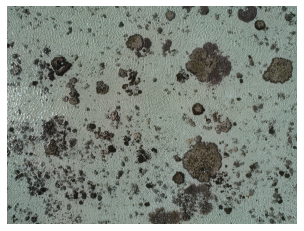

In [ ]:
image = img_as_float(io.imread(imagePath))
SLICsegm_grid = slic(image, n_segments = numSegments, sigma = Sigma)

SPHCsegm_grid = getSPHCsegments(SLICsegm_grid, image, numToMerge = segmentsToMerge, max_dist = distance_limit)

fig = plt.figure("%d Segments Merged" % segmentsToMerge)
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(image, SPHCsegm_grid))
plt.axis("off")
plt.show()

In [ ]:
import time as time

import numpy as np
from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt

import skimage
from skimage.data import coins
from skimage.transform import rescale

from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import AgglomerativeClustering
from sklearn.utils.fixes import parse_version

## Agglomerative Clustering

In [ ]:
import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab.patches import cv2_imshow
from PIL import Image

In [ ]:
img = cv2.imread('/content/DJI_0014.JPG')

In [ ]:
from image_slicer import slice

slice('/content/DJI_0014.JPG', 1000)

img1=cv2.imread('/content/DJI_0014_01_01.png')

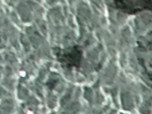

In [ ]:
cv2_imshow(img1)

In [ ]:
#rescaling the image is required to reduce the data size and speed up ther algorithm

scale_percent = 70 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)  
# using the openCV resize function to appropriately resize the image
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

In [ ]:
#convert the MxNx3 image to a Kx3 image where k = MxN
vectorised = img1.reshape((-1,3))

#Convert the array to a dataframe
img_df = pd.DataFrame(vectorised)
img_df.rename(columns={0:'R', 1:'G', 2: 'B'}, inplace =True)

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
labimg = cv2.cvtColor(img1, cv2.COLOR_BGR2LAB)

#n = 0
#while(n<10):
#    labimg = cv2.pyrDown(labimg)
#    n = n+1

feature_image=np.reshape(labimg, [-1, 3])
rows, cols, chs = labimg.shape


clustering = AgglomerativeClustering()


indices = np.dstack(np.indices(labimg.shape[:2]))
xycolors = np.concatenate((labimg, indices), axis=-1) 
feature_image2 = np.reshape(xycolors, [-1,5])
clustering.fit(feature_image2)
labels2 = clustering.labels_

(-0.5, 151.5, 113.5, -0.5)

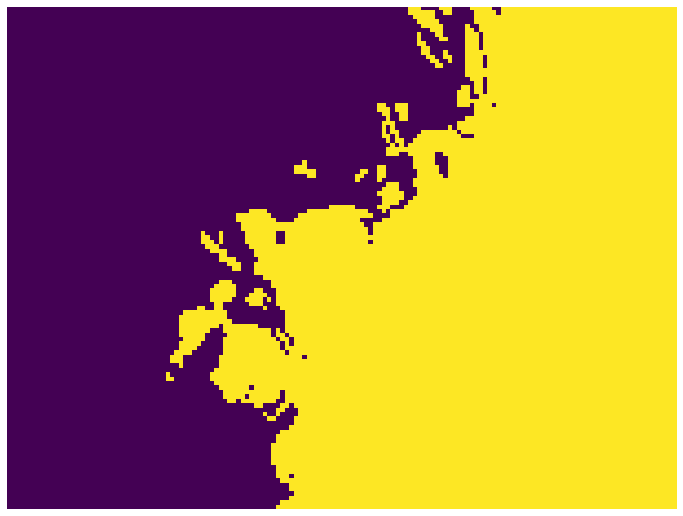

In [ ]:
plt.figure(figsize=(12, 12))
plt.imshow(np.reshape(labels2, [rows, cols]))
plt.axis('off')

## DBSCAN Clustering

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [ ]:
img = cv2.imread('/content/DJI_0014.JPG')

In [ ]:
labimg = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

n = 0
while(n<4):
    labimg = cv2.pyrDown(labimg)
    n = n+1

feature_image=np.reshape(labimg, [-1, 3])
rows, cols, chs = labimg.shape

db = DBSCAN(eps=5, min_samples=2, metric = 'euclidean',algorithm ='auto')
#db.fit(feature_image)
#labels = db.labels_

indices = np.dstack(np.indices(labimg.shape[:2]))
xycolors = np.concatenate((labimg, indices), axis=-1) 
feature_image2 = np.reshape(xycolors, [-1,5])
db.fit(feature_image2)
labels2 = db.labels_

(-0.5, 4863.5, 3647.5, -0.5)

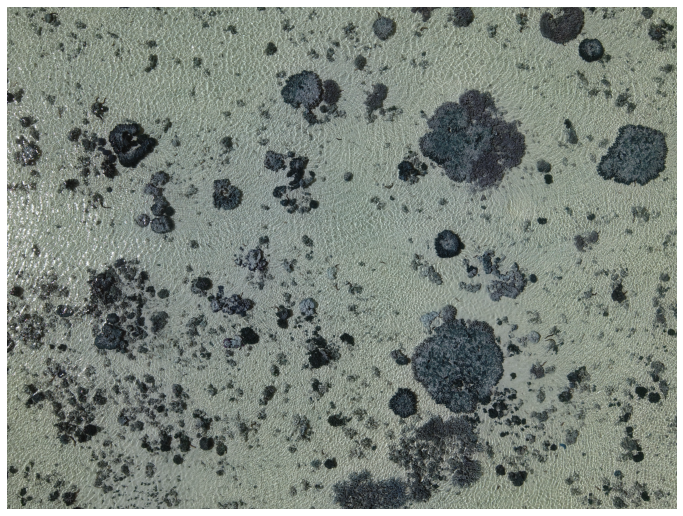

In [ ]:
#plt.figure(2)
#plt.subplot(1, 1, 1)
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis('off')

(-0.5, 303.5, 227.5, -0.5)

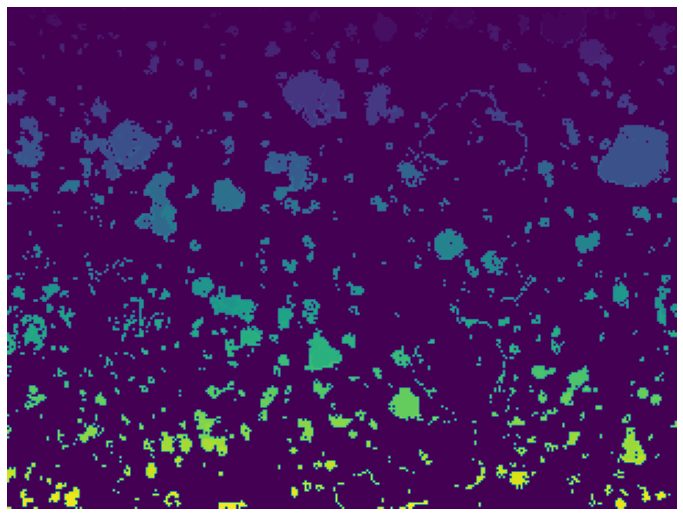

In [ ]:
#plt.subplot(1, 1, 1)
plt.figure(figsize=(12, 12))
plt.imshow(np.reshape(labels2, [rows, cols]))
plt.axis('off')
#plt.show()

(-0.5, 303.5, 227.5, -0.5)

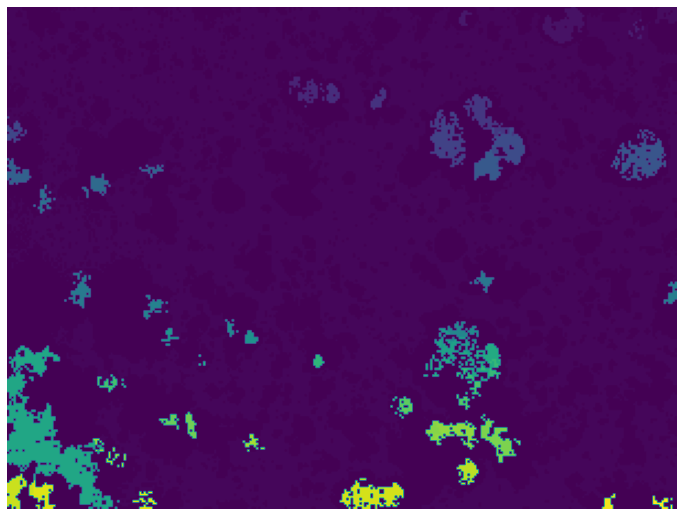

In [ ]:
labimg = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

n = 0
while(n<4):
    labimg = cv2.pyrDown(labimg)
    n = n+1

feature_image=np.reshape(labimg, [-1, 3])
rows, cols, chs = labimg.shape

db = DBSCAN(eps=5, min_samples=20, metric = 'euclidean',algorithm ='auto')
db.fit(feature_image)
labels = db.labels_

indices = np.dstack(np.indices(labimg.shape[:2]))
xycolors = np.concatenate((labimg, indices), axis=-1) 
feature_image2 = np.reshape(xycolors, [-1,5])
db.fit(feature_image2)
labels2 = db.labels_

plt.figure(figsize=(12, 12))
plt.imshow(np.reshape(labels2, [rows, cols]))
plt.axis('off')


(-0.5, 303.5, 227.5, -0.5)

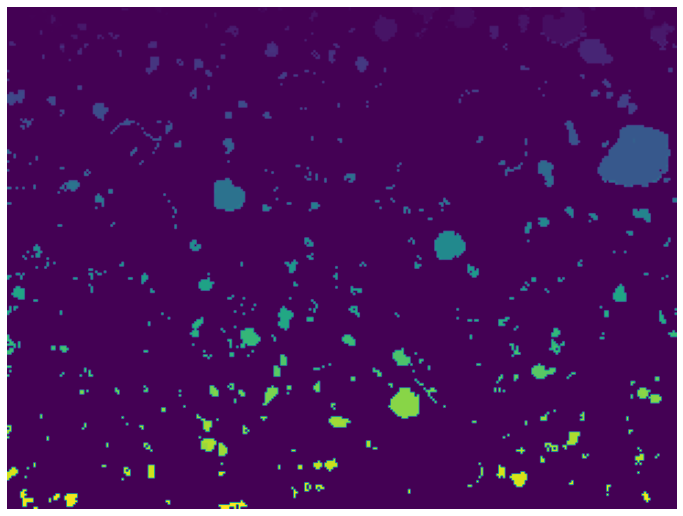

In [ ]:
labimg = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

n = 0
while(n<4):
    labimg = cv2.pyrDown(labimg)
    n = n+1

feature_image=np.reshape(labimg, [-1, 3])
rows, cols, chs = labimg.shape

db = DBSCAN(eps=6, min_samples=2, metric = 'euclidean',algorithm ='auto')
db.fit(feature_image)
labels = db.labels_

indices = np.dstack(np.indices(labimg.shape[:2]))
xycolors = np.concatenate((labimg, indices), axis=-1) 
feature_image2 = np.reshape(xycolors, [-1,5])
db.fit(feature_image2)
labels2 = db.labels_

plt.figure(figsize=(12, 12))
plt.imshow(np.reshape(labels2, [rows, cols]))
plt.axis('off')

(-0.5, 303.5, 227.5, -0.5)

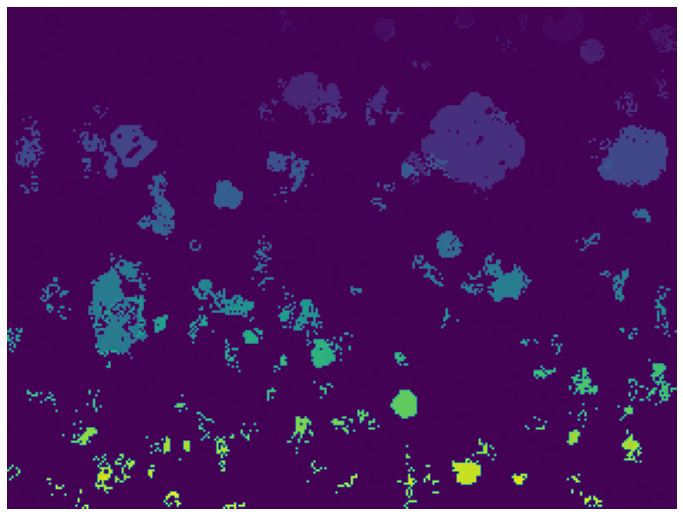

In [ ]:
labimg = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

n = 0
while(n<4):
    labimg = cv2.pyrDown(labimg)
    n = n+1

feature_image=np.reshape(labimg, [-1, 3])
rows, cols, chs = labimg.shape

db = DBSCAN(eps=6, min_samples=10, metric = 'euclidean',algorithm ='auto')
db.fit(feature_image)whatsapp
labels = db.labels_

indices = np.dstack(np.indices(labimg.shape[:2]))
xycolors = np.concatenate((labimg, indices), axis=-1) 
feature_image2 = np.reshape(xycolors, [-1,5])
db.fit(feature_image2)
labels2 = db.labels_

plt.figure(figsize=(12, 12))
plt.imshow(np.reshape(labels2, [rows, cols]))
plt.axis('off')

## Hierarchical Clustering (Grey Scale)

In [14]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [16]:
def fusion(image, iters):
    for greyscale in range(255):
        distance_matrix = abs(image - greyscale)
        i = 0
        distance_range = 1
        while i < iters:
            if distance_range in distance_matrix :
                index = np.argmin(np.ma.masked_where(distance_matrix < distance_range, distance_matrix))
                nearest_pixel = image.item(index)
                image[image == nearest_pixel] = min(greyscale, nearest_pixel)
                distance_range += 1
            i += 1

iteration = int(input("How many fusions ? : "))

img = Image.open('/content/DJI_0014.JPG').convert('L')
imageMat = np.array(img)


fusion(imageMat, iteration)

How many fusions ? : 150


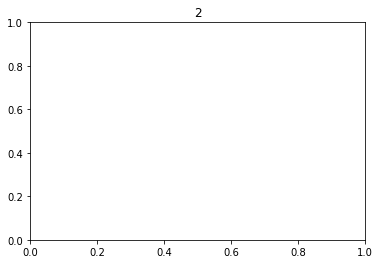

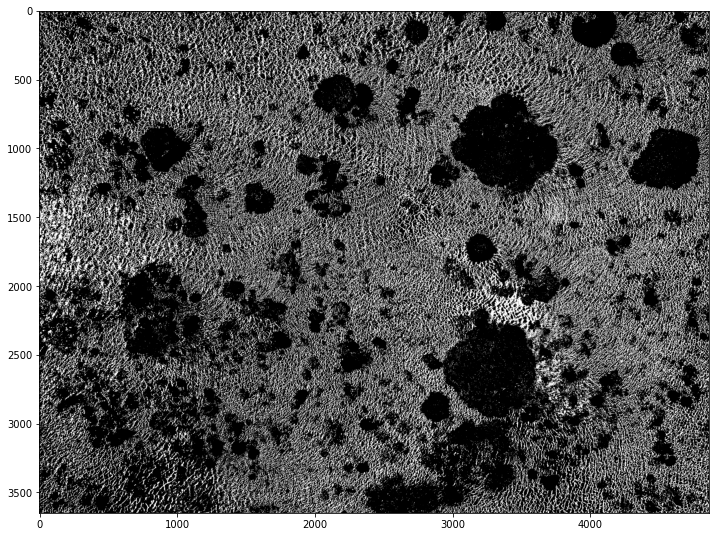

In [17]:
#plt.subplot(1, 2, 2)
plt.title('2')
plt.figure(figsize=(12, 12))
plt.imshow(Image.fromarray(imageMat), cmap='gray')

#plt.show()

## Agglomerative clustering (on grey image)

In [1]:
import time as time
import numpy as np
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import skimage
from skimage.data import coins
from skimage.transform import rescale
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import AgglomerativeClustering
from sklearn.utils.fixes import parse_version
import cv2
from google.colab.patches import cv2_imshow

In [2]:
img = cv2.imread('/content/DJI_0014.JPG')

Compute structured hierarchical clustering...
Elapsed time:  144.5103404521942
Number of pixels:  710290
Number of clusters:  2


(-0.5, 972.5, 729.5, -0.5)

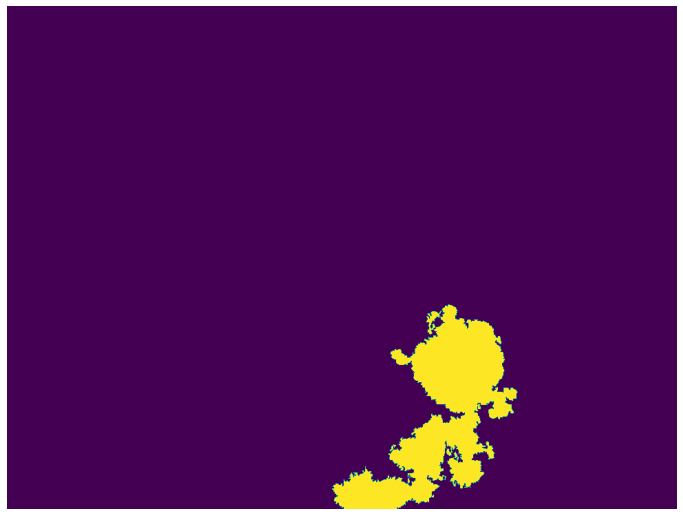

In [3]:
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

if parse_version(skimage.__version__) >= parse_version("0.14"):
    rescale_params = {"anti_aliasing": False, "multichannel": False}
else:
    rescale_params = {}

# #############################################################################
# Resize it to 20% of the original size to speed up the processing
# Applying a Gaussian filter for smoothing prior to down-scaling
# reduces aliasing artifacts.
smoothened_img = gaussian_filter(img, sigma=2)
rescaled_img = rescale(smoothened_img, 0.2, mode="reflect", **rescale_params)

X = np.reshape(rescaled_img, (-1, 1))

# #############################################################################
# Define the structure A of the data. Pixels connected to their neighbors.
connectivity = grid_to_graph(*rescaled_img.shape)

# #############################################################################
# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
n_clusters = 2  # number of regions
ward = AgglomerativeClustering(
    n_clusters=n_clusters, linkage="ward", connectivity=connectivity
)
ward.fit(X)
label = np.reshape(ward.labels_, rescaled_img.shape)
print("Elapsed time: ", time.time() - st)
print("Number of pixels: ", label.size)
print("Number of clusters: ", np.unique(label).size)

# #############################################################################
plt.figure(figsize=(12, 12))
plt.imshow(label)
plt.axis('off')

Compute structured hierarchical clustering...
Elapsed time:  148.18224906921387
Number of pixels:  710290
Number of clusters:  3


(-0.5, 972.5, 729.5, -0.5)

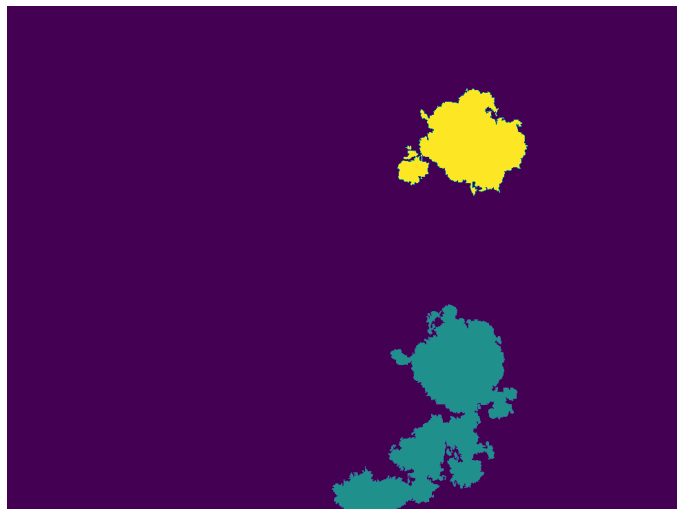

In [5]:
img = cv2.imread('/content/DJI_0014.JPG')

img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

if parse_version(skimage.__version__) >= parse_version("0.14"):
    rescale_params = {"anti_aliasing": False, "multichannel": False}
else:
    rescale_params = {}

# #############################################################################
# Resize it to 20% of the original size to speed up the processing
# Applying a Gaussian filter for smoothing prior to down-scaling
# reduces aliasing artifacts.
smoothened_img = gaussian_filter(img, sigma=2)
rescaled_img = rescale(smoothened_img, 0.2, mode="reflect", **rescale_params)

X = np.reshape(rescaled_img, (-1, 1))

# #############################################################################
# Define the structure A of the data. Pixels connected to their neighbors.
connectivity = grid_to_graph(*rescaled_img.shape)

# #############################################################################
# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
n_clusters = 3  # number of regions
ward = AgglomerativeClustering(
    n_clusters=n_clusters, linkage="ward", connectivity=connectivity
)
ward.fit(X)
label = np.reshape(ward.labels_, rescaled_img.shape)
print("Elapsed time: ", time.time() - st)
print("Number of pixels: ", label.size)
print("Number of clusters: ", np.unique(label).size)

# #############################################################################
plt.figure(figsize=(12, 12))
plt.imshow(label)
plt.axis('off')

Compute structured hierarchical clustering...
Elapsed time:  147.06849193572998
Number of pixels:  710290
Number of clusters:  4


(-0.5, 972.5, 729.5, -0.5)

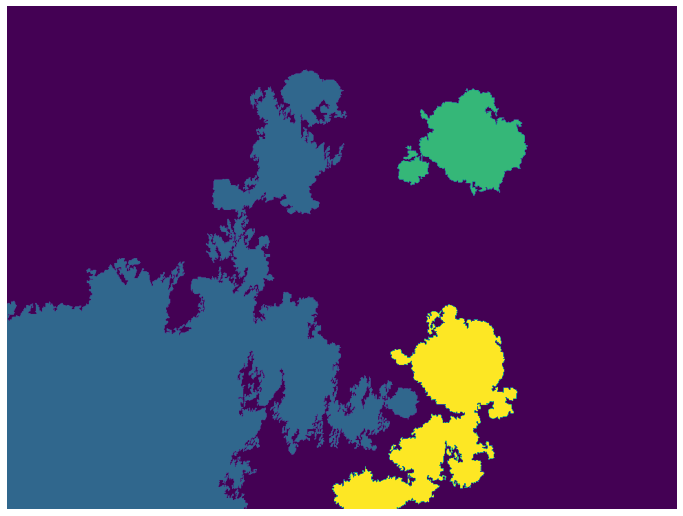

In [6]:
img = cv2.imread('/content/DJI_0014.JPG')

img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

if parse_version(skimage.__version__) >= parse_version("0.14"):
    rescale_params = {"anti_aliasing": False, "multichannel": False}
else:
    rescale_params = {}

# #############################################################################
# Resize it to 20% of the original size to speed up the processing
# Applying a Gaussian filter for smoothing prior to down-scaling
# reduces aliasing artifacts.
smoothened_img = gaussian_filter(img, sigma=2)
rescaled_img = rescale(smoothened_img, 0.2, mode="reflect", **rescale_params)

X = np.reshape(rescaled_img, (-1, 1))

# #############################################################################
# Define the structure A of the data. Pixels connected to their neighbors.
connectivity = grid_to_graph(*rescaled_img.shape)

# #############################################################################
# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
n_clusters = 4  # number of regions
ward = AgglomerativeClustering(
    n_clusters=n_clusters, linkage="ward", connectivity=connectivity
)
ward.fit(X)
label = np.reshape(ward.labels_, rescaled_img.shape)
print("Elapsed time: ", time.time() - st)
print("Number of pixels: ", label.size)
print("Number of clusters: ", np.unique(label).size)

# #############################################################################
plt.figure(figsize=(12, 12))
plt.imshow(label)
plt.axis('off')

Compute structured hierarchical clustering...
Elapsed time:  146.8638083934784
Number of pixels:  710290
Number of clusters:  5


(-0.5, 972.5, 729.5, -0.5)

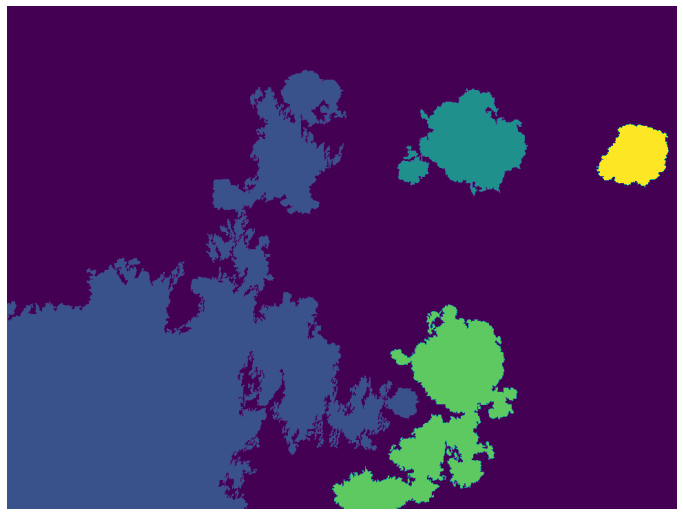

In [7]:
img = cv2.imread('/content/DJI_0014.JPG')

img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

if parse_version(skimage.__version__) >= parse_version("0.14"):
    rescale_params = {"anti_aliasing": False, "multichannel": False}
else:
    rescale_params = {}

# #############################################################################
# Resize it to 20% of the original size to speed up the processing
# Applying a Gaussian filter for smoothing prior to down-scaling
# reduces aliasing artifacts.
smoothened_img = gaussian_filter(img, sigma=2)
rescaled_img = rescale(smoothened_img, 0.2, mode="reflect", **rescale_params)

X = np.reshape(rescaled_img, (-1, 1))

# #############################################################################
# Define the structure A of the data. Pixels connected to their neighbors.
connectivity = grid_to_graph(*rescaled_img.shape)

# #############################################################################
# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
n_clusters = 5  # number of regions
ward = AgglomerativeClustering(
    n_clusters=n_clusters, linkage="ward", connectivity=connectivity
)
ward.fit(X)
label = np.reshape(ward.labels_, rescaled_img.shape)
print("Elapsed time: ", time.time() - st)
print("Number of pixels: ", label.size)
print("Number of clusters: ", np.unique(label).size)

# #############################################################################
plt.figure(figsize=(12, 12))
plt.imshow(label)
plt.axis('off')

Compute structured hierarchical clustering...
Elapsed time:  145.51050209999084
Number of pixels:  710290
Number of clusters:  6


(-0.5, 972.5, 729.5, -0.5)

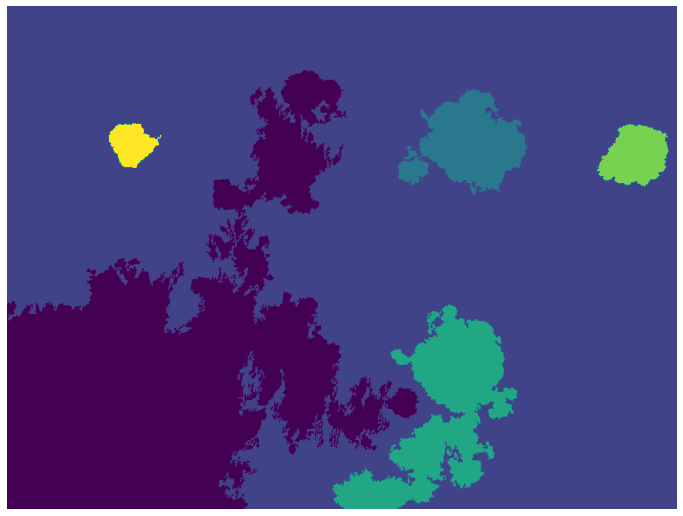

In [8]:
img = cv2.imread('/content/DJI_0014.JPG')

img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

if parse_version(skimage.__version__) >= parse_version("0.14"):
    rescale_params = {"anti_aliasing": False, "multichannel": False}
else:
    rescale_params = {}

# #############################################################################

# Resize it to 20% of the original size to speed up the processing
# Applying a Gaussian filter for smoothing prior to down-scaling
# reduces aliasing artifacts.
smoothened_img = gaussian_filter(img, sigma=2)
rescaled_img = rescale(smoothened_img, 0.2, mode="reflect", **rescale_params)

X = np.reshape(rescaled_img, (-1, 1))

# #############################################################################
# Define the structure A of the data. Pixels connected to their neighbors.
connectivity = grid_to_graph(*rescaled_img.shape)

# #############################################################################
# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
n_clusters = 6  # number of regions
ward = AgglomerativeClustering(
    n_clusters=n_clusters, linkage="ward", connectivity=connectivity
)
ward.fit(X)
label = np.reshape(ward.labels_, rescaled_img.shape)
print("Elapsed time: ", time.time() - st)
print("Number of pixels: ", label.size)
print("Number of clusters: ", np.unique(label).size)

# #############################################################################
plt.figure(figsize=(12, 12))
plt.imshow(label)
plt.axis('off')

Compute structured hierarchical clustering...
Elapsed time:  142.02173328399658
Number of pixels:  710290
Number of clusters:  7


(-0.5, 972.5, 729.5, -0.5)

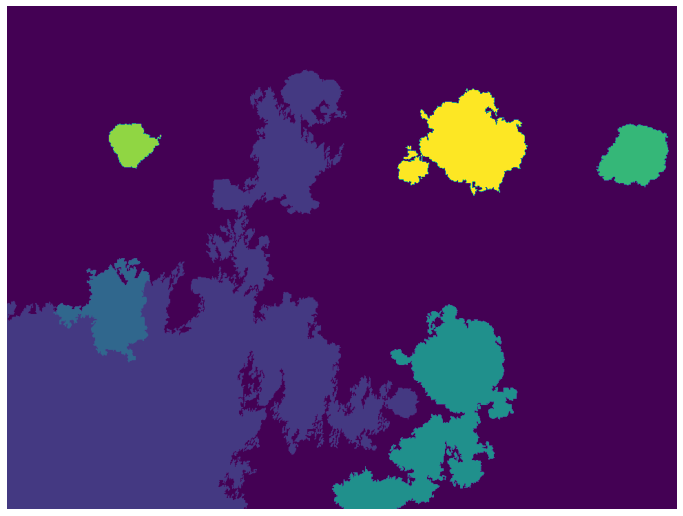

In [9]:
img = cv2.imread('/content/DJI_0014.JPG')

img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

if parse_version(skimage.__version__) >= parse_version("0.14"):
    rescale_params = {"anti_aliasing": False, "multichannel": False}
else:
    rescale_params = {}

# #############################################################################
# Resize it to 20% of the original size to speed up the processing
# Applying a Gaussian filter for smoothing prior to down-scaling
# reduces aliasing artifacts.
smoothened_img = gaussian_filter(img, sigma=2)
rescaled_img = rescale(smoothened_img, 0.2, mode="reflect", **rescale_params)

X = np.reshape(rescaled_img, (-1, 1))

# #############################################################################
# Define the structure A of the data. Pixels connected to their neighbors.
connectivity = grid_to_graph(*rescaled_img.shape)

# #############################################################################
# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
n_clusters = 7  # number of regions
ward = AgglomerativeClustering(
    n_clusters=n_clusters, linkage="ward", connectivity=connectivity
)
ward.fit(X)
label = np.reshape(ward.labels_, rescaled_img.shape)
print("Elapsed time: ", time.time() - st)
print("Number of pixels: ", label.size)
print("Number of clusters: ", np.unique(label).size)

# #############################################################################
plt.figure(figsize=(12, 12))
plt.imshow(label)
plt.axis('off')

Compute structured hierarchical clustering...
Elapsed time:  144.18003129959106
Number of pixels:  710290
Number of clusters:  12


(-0.5, 972.5, 729.5, -0.5)

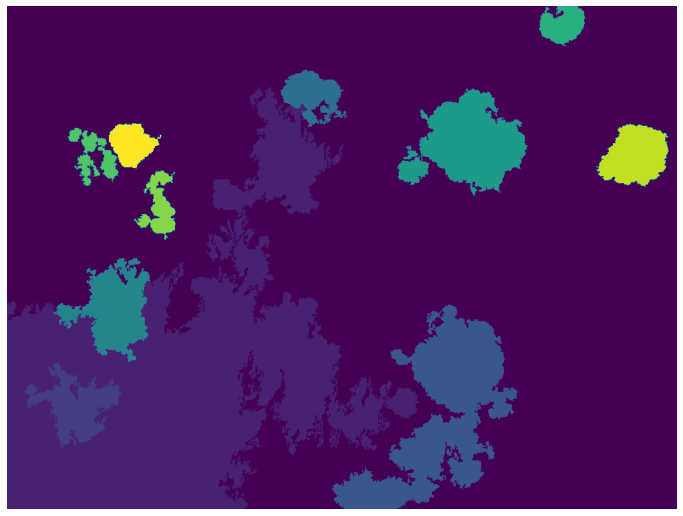

In [10]:
img = cv2.imread('/content/DJI_0014.JPG')

img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

if parse_version(skimage.__version__) >= parse_version("0.14"):
    rescale_params = {"anti_aliasing": False, "multichannel": False}
else:
    rescale_params = {}

# #############################################################################

# Resize it to 20% of the original size to speed up the processing
# Applying a Gaussian filter for smoothing prior to down-scaling
# reduces aliasing artifacts.
smoothened_img = gaussian_filter(img, sigma=2)
rescaled_img = rescale(smoothened_img, 0.2, mode="reflect", **rescale_params)

X = np.reshape(rescaled_img, (-1, 1))

# #############################################################################
# Define the structure A of the data. Pixels connected to their neighbors.
connectivity = grid_to_graph(*rescaled_img.shape)

# #############################################################################
# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
n_clusters = 12  # number of regions
ward = AgglomerativeClustering(
    n_clusters=n_clusters, linkage="ward", connectivity=connectivity
)
ward.fit(X)
label = np.reshape(ward.labels_, rescaled_img.shape)
print("Elapsed time: ", time.time() - st)
print("Number of pixels: ", label.size)
print("Number of clusters: ", np.unique(label).size)

# #############################################################################
plt.figure(figsize=(12, 12))
plt.imshow(label)
plt.axis('off')

## Kmeans

In [7]:
!pip install rasterio

     |████████████████████████████████| 19.3 MB 351 kB/s 


In [8]:
import rasterio
from rasterio.plot import show
import numpy as np
from sklearn import cluster
from osgeo import gdal, gdal_array
import matplotlib.pyplot as plt

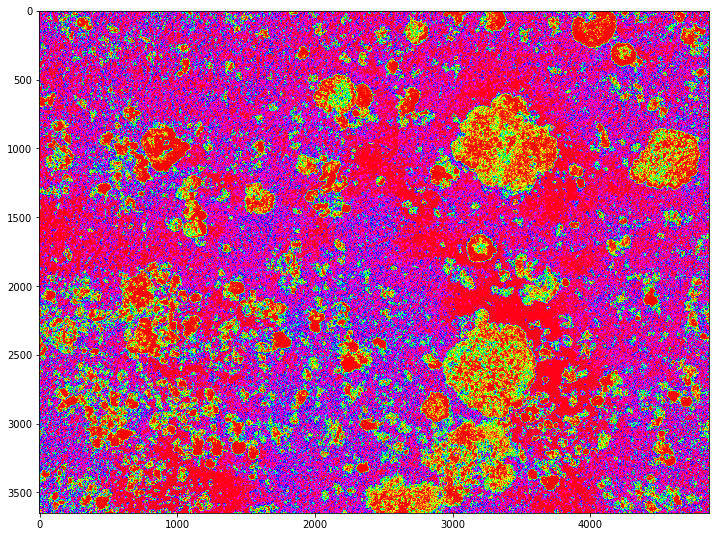

In [14]:
# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

fp = r'/content/DJI_0014.JPG'
img_ds = gdal.Open(fp, gdal.GA_ReadOnly) #reads as gdal.dataset object

# loading a multi-band image into a numpy
img=np.zeros((img_ds.RasterYSize,img_ds.RasterXSize,img_ds.RasterCount),gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
#print("Band sise",img.shape[2])

for b in range(img.shape[2]):
    img[:,:,b]=img_ds.GetRasterBand(b + 1).ReadAsArray()
#reshaping array:
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
X= img[:,:,:img.shape[2]].reshape(new_shape)

#k-nn Clusterinng
k_means = cluster.KMeans(n_clusters=2)
k_means.fit(X)

X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(img[:, :, 0].shape)

plt.figure(figsize=(12,12))
plt.imshow(X_cluster, cmap="hsv")
plt.show()

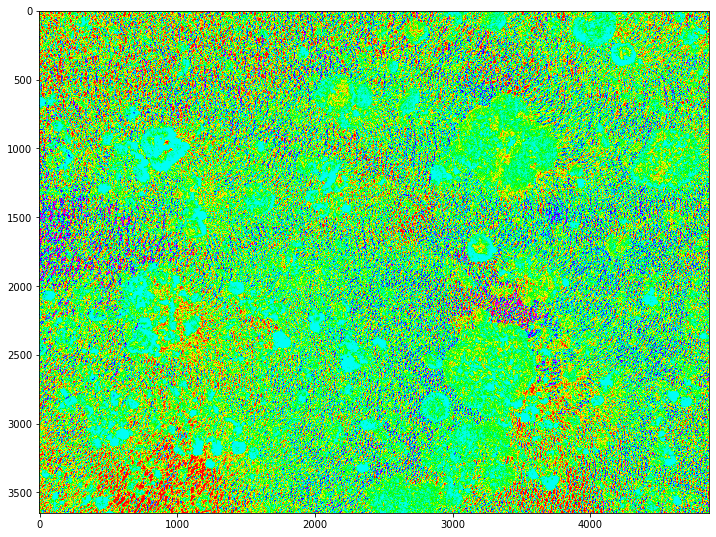

In [15]:
#k-nn Clusterinng
k_means = cluster.KMeans(n_clusters=3)
k_means.fit(X)

X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(img[:, :, 0].shape)

plt.figure(figsize=(12,12))
plt.imshow(X_cluster, cmap="hsv")
plt.show()

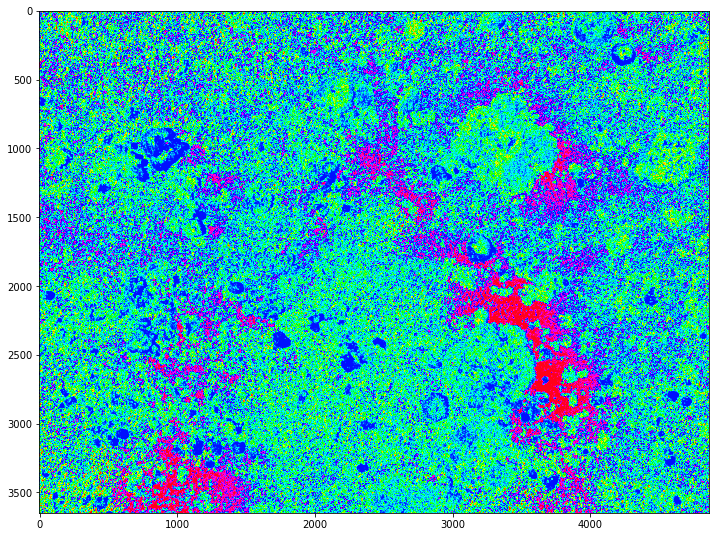

In [16]:
#k-nn Clusterinng
k_means = cluster.KMeans(n_clusters=4)
k_means.fit(X)

X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(img[:, :, 0].shape)

plt.figure(figsize=(12,12))
plt.imshow(X_cluster, cmap="hsv")
plt.show()

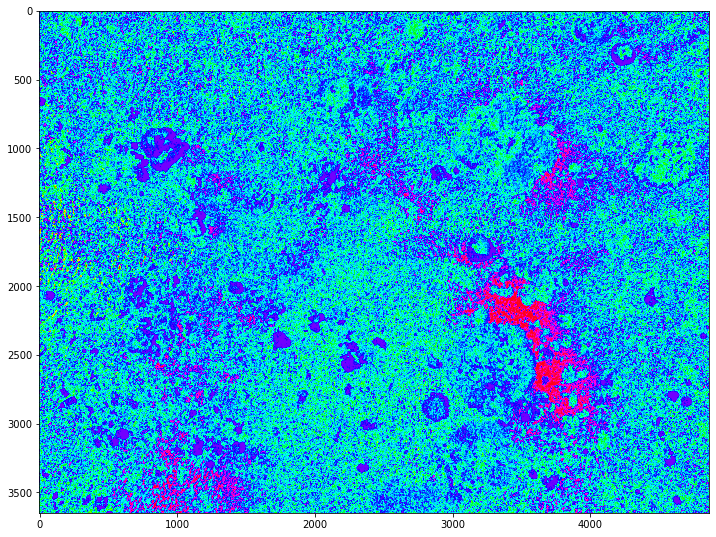

In [17]:
#k-nn Clusterinng
k_means = cluster.KMeans(n_clusters=5)
k_means.fit(X)

X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(img[:, :, 0].shape)

plt.figure(figsize=(12,12))
plt.imshow(X_cluster, cmap="hsv")
plt.show()

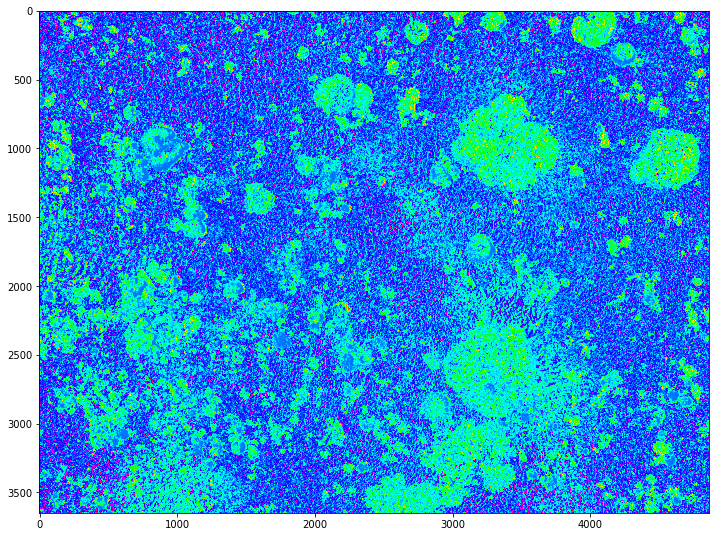

In [18]:
#k-nn Clusterinng
k_means = cluster.KMeans(n_clusters=6)
k_means.fit(X)

X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(img[:, :, 0].shape)

plt.figure(figsize=(12,12))
plt.imshow(X_cluster, cmap="hsv")
plt.show()

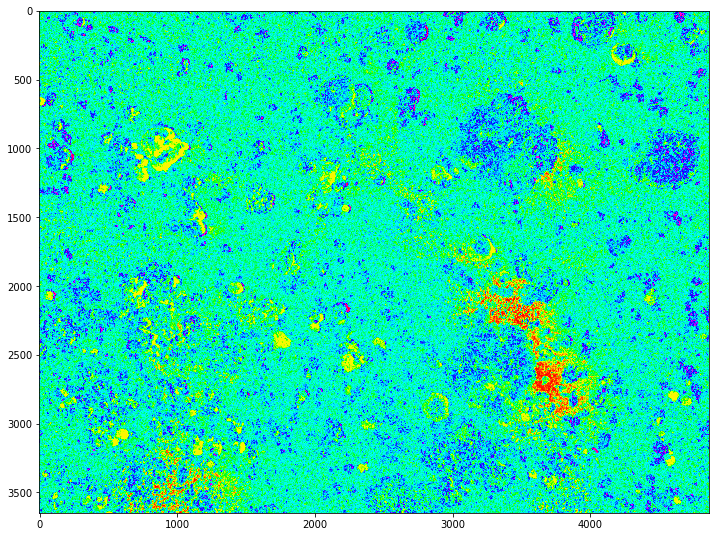

In [19]:
#k-nn Clusterinng
k_means = cluster.KMeans(n_clusters=7)
k_means.fit(X)

X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(img[:, :, 0].shape)

plt.figure(figsize=(12,12))
plt.imshow(X_cluster, cmap="hsv")
plt.show()

## GMM

In [20]:
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot
import rasterio
from rasterio.plot import show
import numpy as np
from sklearn import cluster
from osgeo import gdal, gdal_array
import matplotlib.pyplot as plt

In [21]:
# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

fp = r'/content/DJI_0014.JPG'
img_ds = gdal.Open(fp, gdal.GA_ReadOnly) #reads as gdal.dataset object

# loading a multi-band image into a numpy
img=np.zeros((img_ds.RasterYSize,img_ds.RasterXSize,img_ds.RasterCount),gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
#print("Band sise",img.shape[2])

for b in range(img.shape[2]):
    img[:,:,b]=img_ds.GetRasterBand(b + 1).ReadAsArray()
#reshaping array:
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
X= img[:,:,:img.shape[2]].reshape(new_shape)

In [ ]:
#k-nn Clusterinng
k_means = cluster.KMeans(n_clusters=6)
k_means.fit(X)

X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(img[:, :, 0].shape)

plt.figure(figsize=(12,12))
plt.imshow(X_cluster, cmap="hsv")
plt.show()

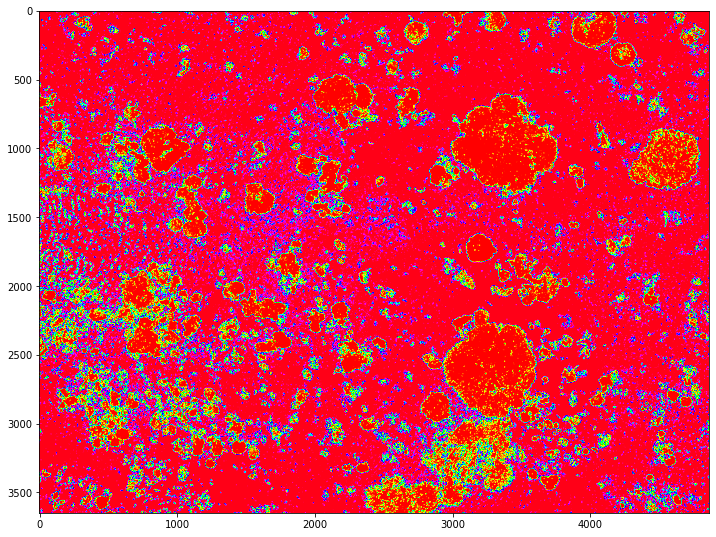

In [22]:
# define the model
model = GaussianMixture(n_components=2)
# fit the model
model.fit(X)
labels = model.predict(X)

X_cluster = labels
X_cluster = X_cluster.reshape(img[:, :, 0].shape)

plt.figure(figsize=(12,12))
plt.imshow(X_cluster, cmap="hsv")
plt.show()